<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/waves/numericalDiffraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Analysis of diffraction between two planes
## David Brady
## University of Arizona
## May 2021

This notebook presents the angular spectrum method for modeling field propagation between two planes. 


## libraries

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})
from google.colab import files
from skimage.transform import rescale



## Angular spectrum diffraction

The field $g(x,y)$ at an output plane at $z=d$ is related to the field $f(x,y)$ at the input plane $z=0$ according to 
$$
g(x,y)={\cal F}^{-1}\left \lbrace F(u,v)e^{i2\pi z\sqrt{\frac{1}{\lambda^2}-u^2-v^2}}\right \rbrace
$$

This transformation may be implemented using the discrete Fourier transform. The sampling period $\Delta$ in the input plane is determined by the bandwidth of $f(x,y)$ and the number of samples in each dimension $N=\frac{2 X}{\Delta}$ is determined by the spatial support $[-X,X]$ of $f(x,y)$. With a simple transformation, the support of the output plane after the second Fourier transform is also $[-X,X]$ and the sampling period remains $\Delta$. Since the support of the field tends to grow by $2 d\frac{\lambda}{\Delta}$, it is necessary to zero pad the input plane by this spatial extent to avoid aliasing in the simulated diffracted field.

Here we define $lam =\frac{\lambda}{\Delta_x}$.The support of the signal in Fourier space is $[-B,B]$ where $B=\frac{1}{2\Delta}=\frac{N}{4X}$. The sampling rate in Fourier space is $\Delta_u=\frac{2B}{N}=\frac{1}{N\Delta}$. Thus

\begin{align}
G(n\Delta_u,m\Delta_u)&=F(n\Delta_u,m\Delta_u)e^{i2\pi z\sqrt{\frac{1}{\lambda^2}-n^2\Delta_u^2-m^2\Delta_u^2}}\\
&=F(n\Delta_u,m\Delta_u)e^{i2\pi \frac{z}{\lambda}\sqrt{1-\frac{n^2lam^2+m^2lam^2}{N^2}}}\\
\end{align}

To evaluate the diffracted field, consider a discretely sampled field $f_{nm}$ where the support of the field in wavelenths is $\frac{X}{\lambda}=\frac{N}{2 lam}$



In [10]:
def g(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
#
  zPad=np.int(np.abs(d)*lam/4)
  inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d)*np.sqrt( 1 - u**2 - v**2))))
  return g

### rectancular object

In [12]:
N=30
lam=.3
f=np.ones([N,N])*(1-1j)

Text(0, 0.5, 'wavelengths')

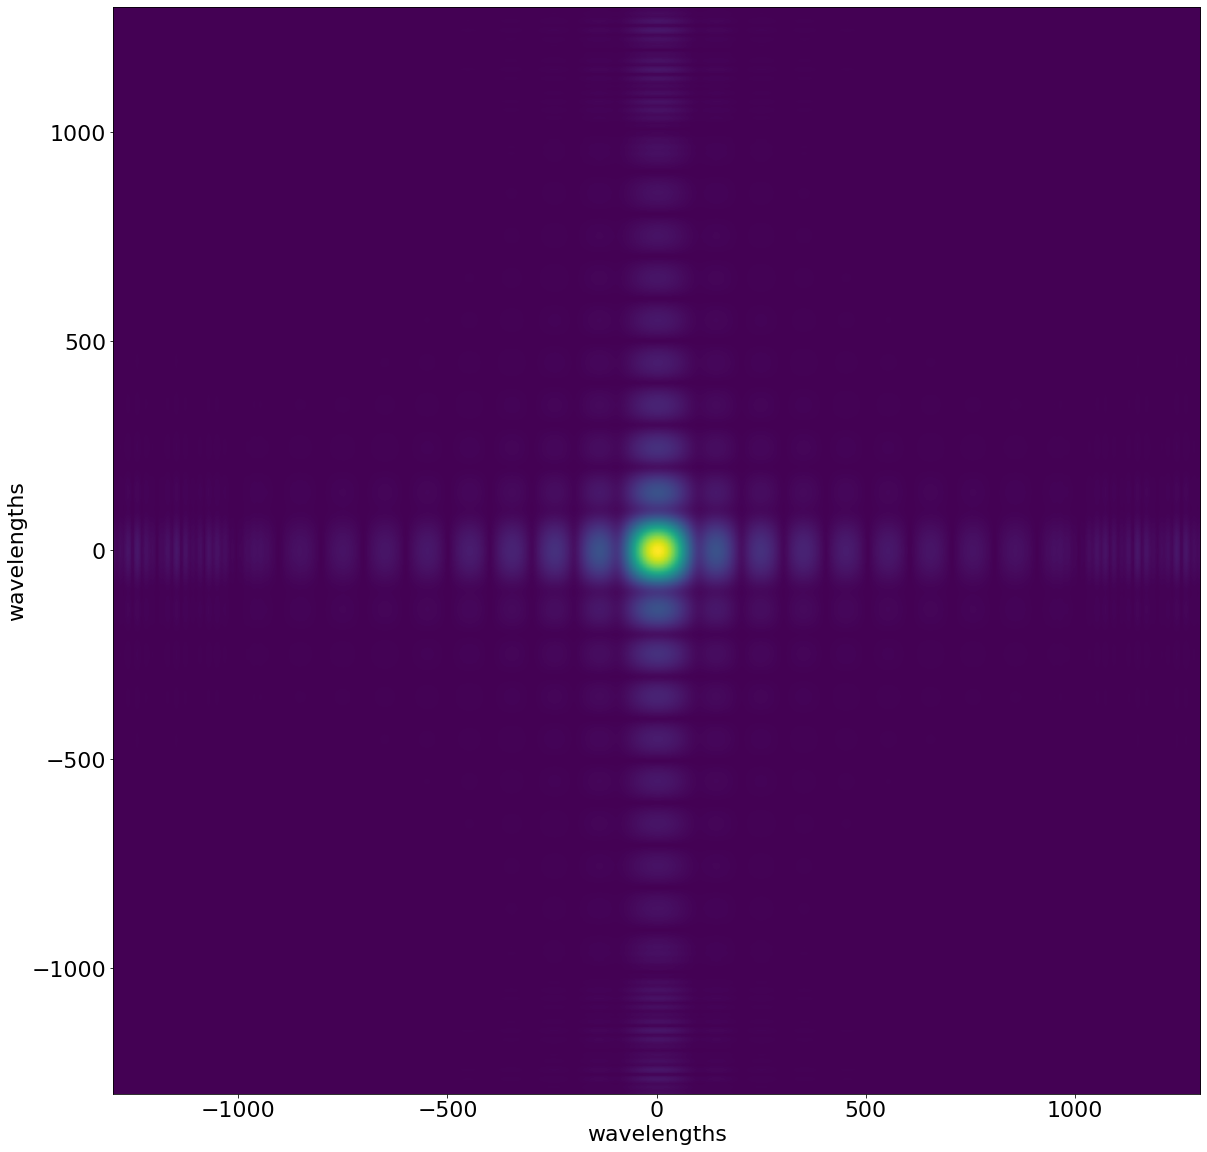

In [13]:
q=g(f,10000,.3)
xrange=q.shape[0]/(lam*2)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

### Gaussian beam

Analytically, the amplitude of a Gaussian mode is described by 
$$g(x,y,z)=\frac{w_o}{w(z)}e^{-\frac{(x^2+y^2)}{w(z)^2}}e^{-i\left(\frac{(x^2+y^2)}{R(z)}-\psi(z)\right )}$$
where $w(z)=w_o\sqrt{1+\frac{z^2}{z_R^2}}$, $z_R=\frac{\pi w_o^2}{\lambda}$, $R(z)=z(1+\frac{z_R^2}{z^2})$ and $\psi(z)=\tan^{-1}(\frac{z}{z_R})$
If $z>>z_R$, then the beam width is
$$w(z)\approx z\frac{\lambda}{\pi w_o}$$
Here we compare numerical and analytic diffraction of Gaussian beams.

In [7]:
def gB(x,y,z,wo):
  # gaussian beam amplitude as a function of x, y, z for all values in units of wavelength.
  zr=np.pi*wo**2/z
  rz=z*(1+zr**2)
  psi=np.arctan(1/zr)
  wz=wo*np.sqrt(1+(1/zr)**2)
  gg=(wo/wz)*np.exp(-(x**2+y**2)/wz**2)*np.exp(-1j*((x**2+y**2)/rz-psi))
  return gg

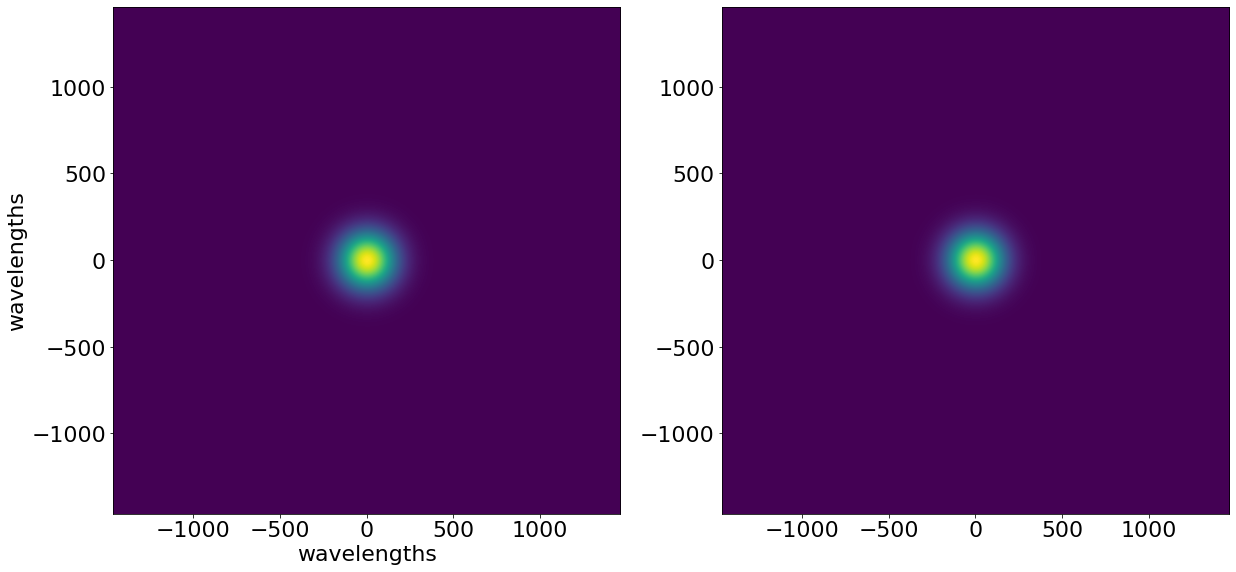

In [14]:
N=128
lam=.3
xInrange=N/(2*lam)
wo=20
z=10000
xp=np.linspace(-xInrange,xInrange,N)
x,y = np.meshgrid(xp,xp)
f=np.exp(-(x**2+y**2)/wo**2)
q=g(f,z,.3)
xrange=q.shape[0]/(2*lam)
plt.subplot(1,2,1)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(1,2,2)
xp=np.linspace(-xrange,xrange,q.shape[0])
xx,yy = np.meshgrid(xp,xp)
plt.imshow(np.abs(gB(xx,yy,z,wo)),extent=[-xrange,xrange,-xrange,xrange])

### Harmonically modulated Gaussian Beam

Text(0, 0.5, 'wavelengths')

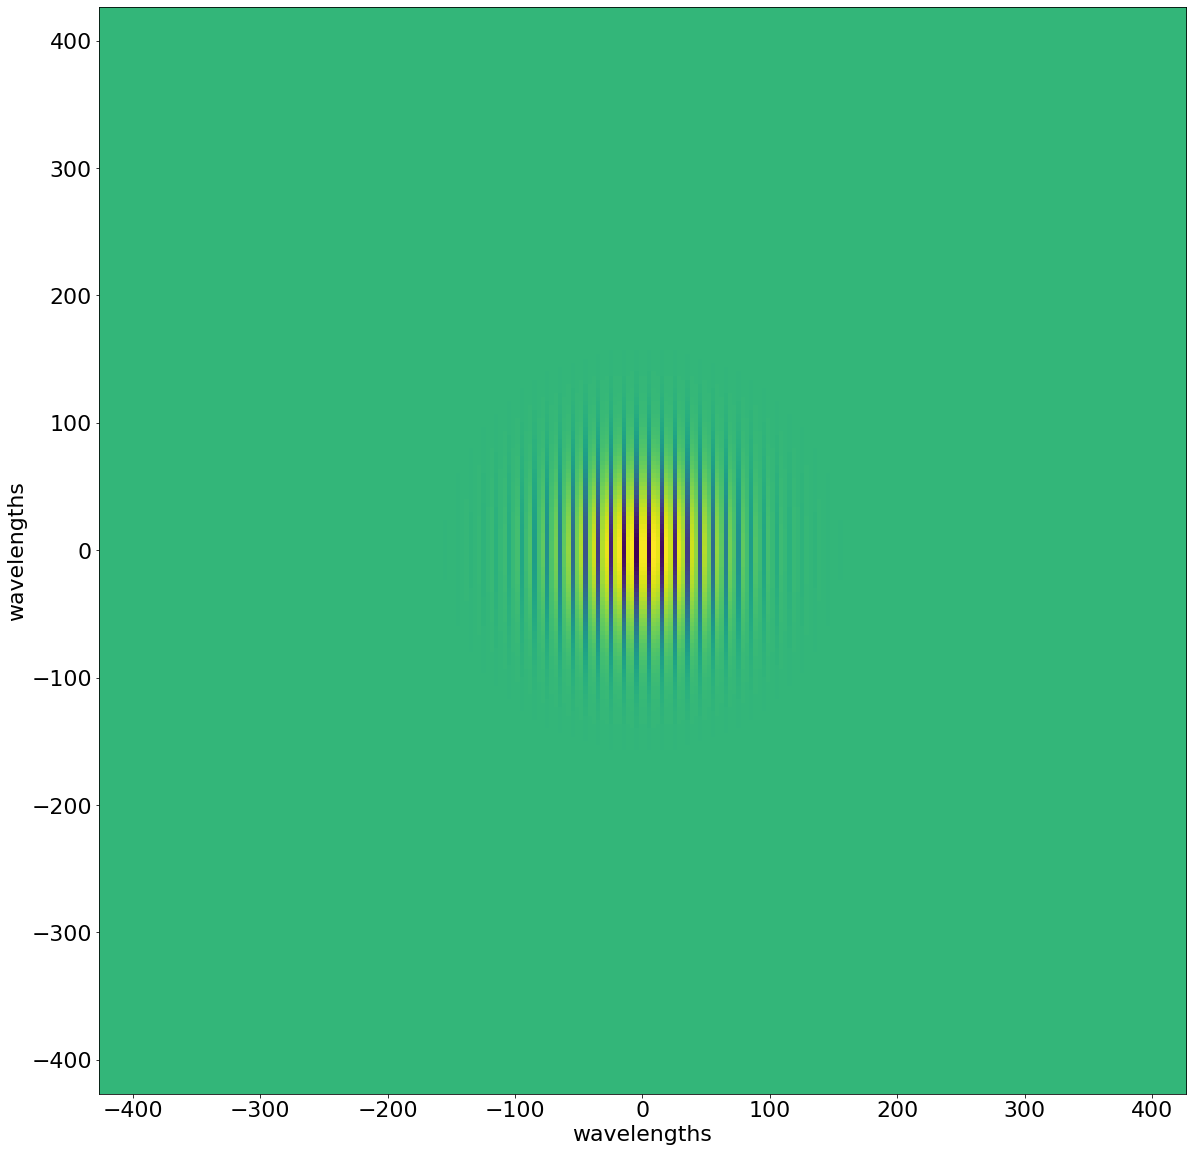

In [15]:
N=256
lam=.3
xrange=N/(lam*2)
xp=np.linspace(-xrange,xrange,N)
x,y = np.meshgrid(xp,xp)
# need to make sure that lam reflects sufficient sampling. here the period of the beam is lambda/10, so lam=.3 is 3 samples per period
f=np.cos(2*np.pi*x/10)*np.exp(-(x**2+y**2)/4000)
plt.imshow(f,extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

Text(0, 0.5, 'wavelengths')

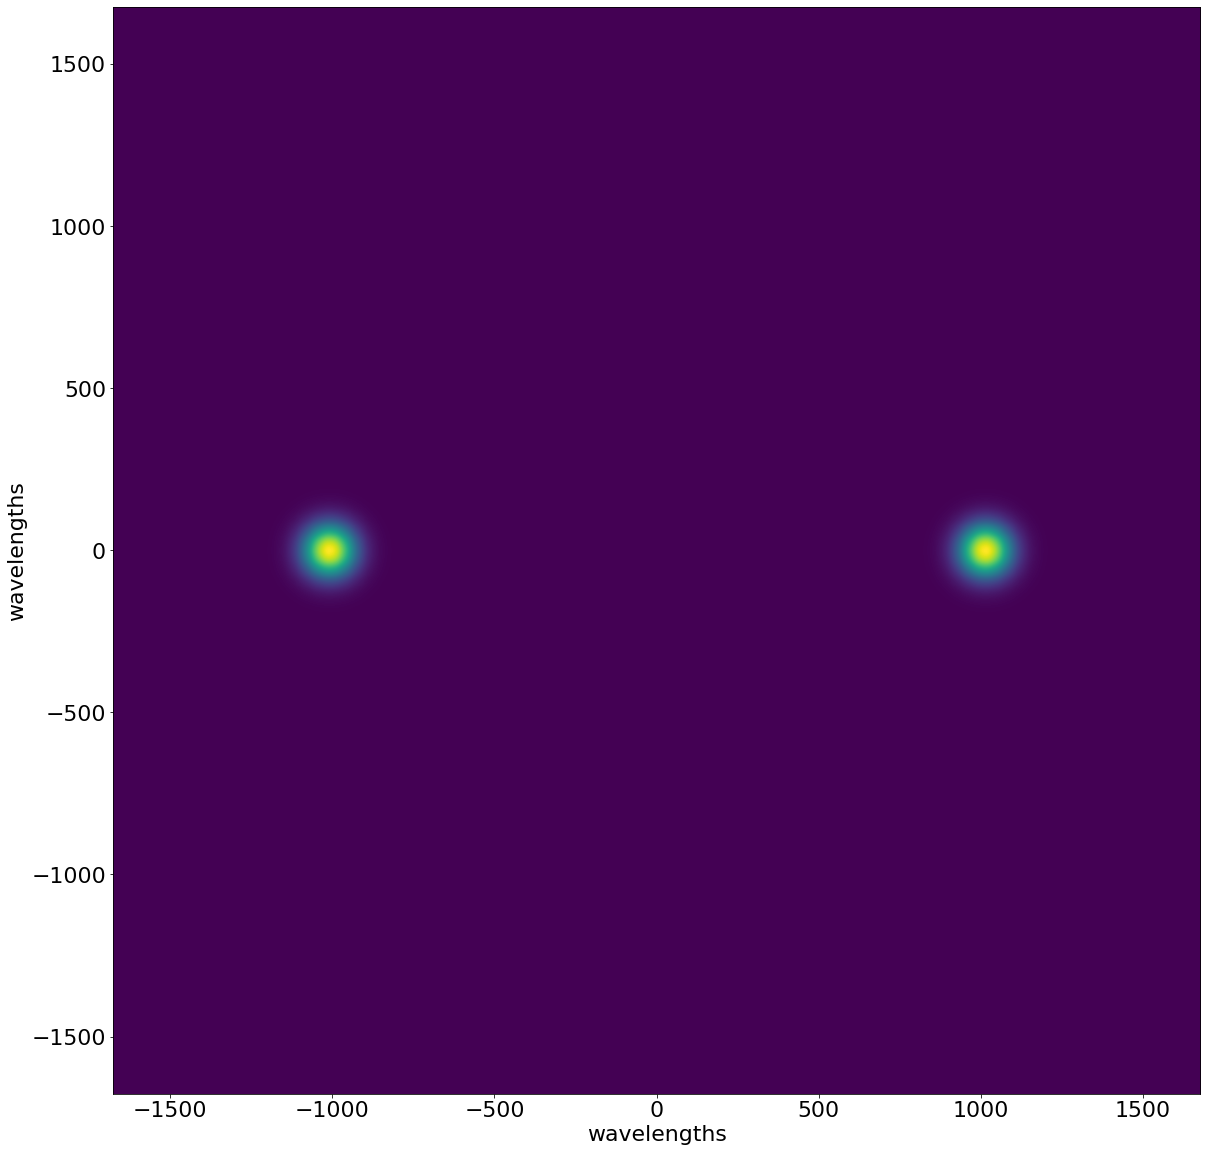

In [16]:
q=g(f,10000,lam)
xrange=q.shape[0]/(2*lam)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

In [17]:
# at z = 10000 wavelengths, the diffracted shift of the beam in wavelenghts should be:
10000*np.tan(np.arcsin(1/10))

1005.0378152592122

### Modulated Annulus

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

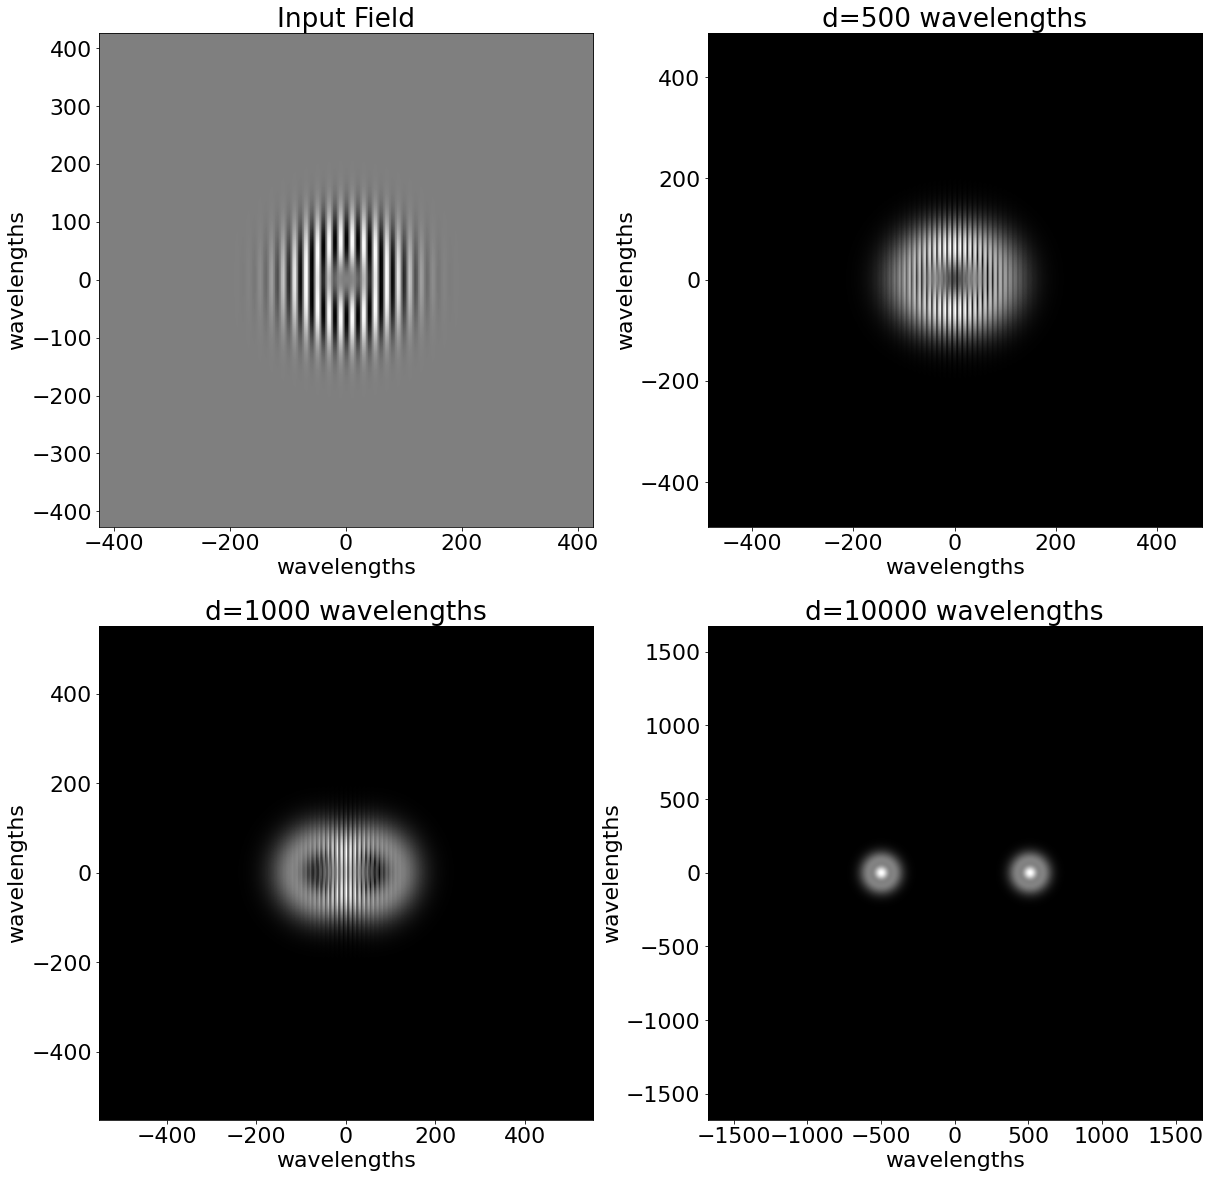

In [18]:
N=256
lam=.3
xrange=N/(2*lam)
xp=np.linspace(-xrange,xrange,N)
x,y = np.meshgrid(xp,xp)
f=np.cos(2*np.pi*x/20)*(np.exp(-(x**2+y**2)/4000)-np.exp(-(x**2+y**2)/5000))
plt.subplot(2,2,1)
plt.imshow(f,extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('Input Field')
plt.subplot(2,2,2)
d=500
q=g(f,d,.3)
xrange=q.shape[0]/(2*lam)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('d=500 wavelengths')
plt.subplot(2,2,3)
d=1000
q=g(f,d,.3)
xrange=q.shape[0]/(2*lam)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('d=1000 wavelengths')
plt.subplot(2,2,4)
d=10000
q=g(f,d,.3)
xrange=q.shape[0]/(2*lam)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('d=10000 wavelengths')
plt.savefig('annulus.pdf')
files.download('annulus.pdf')

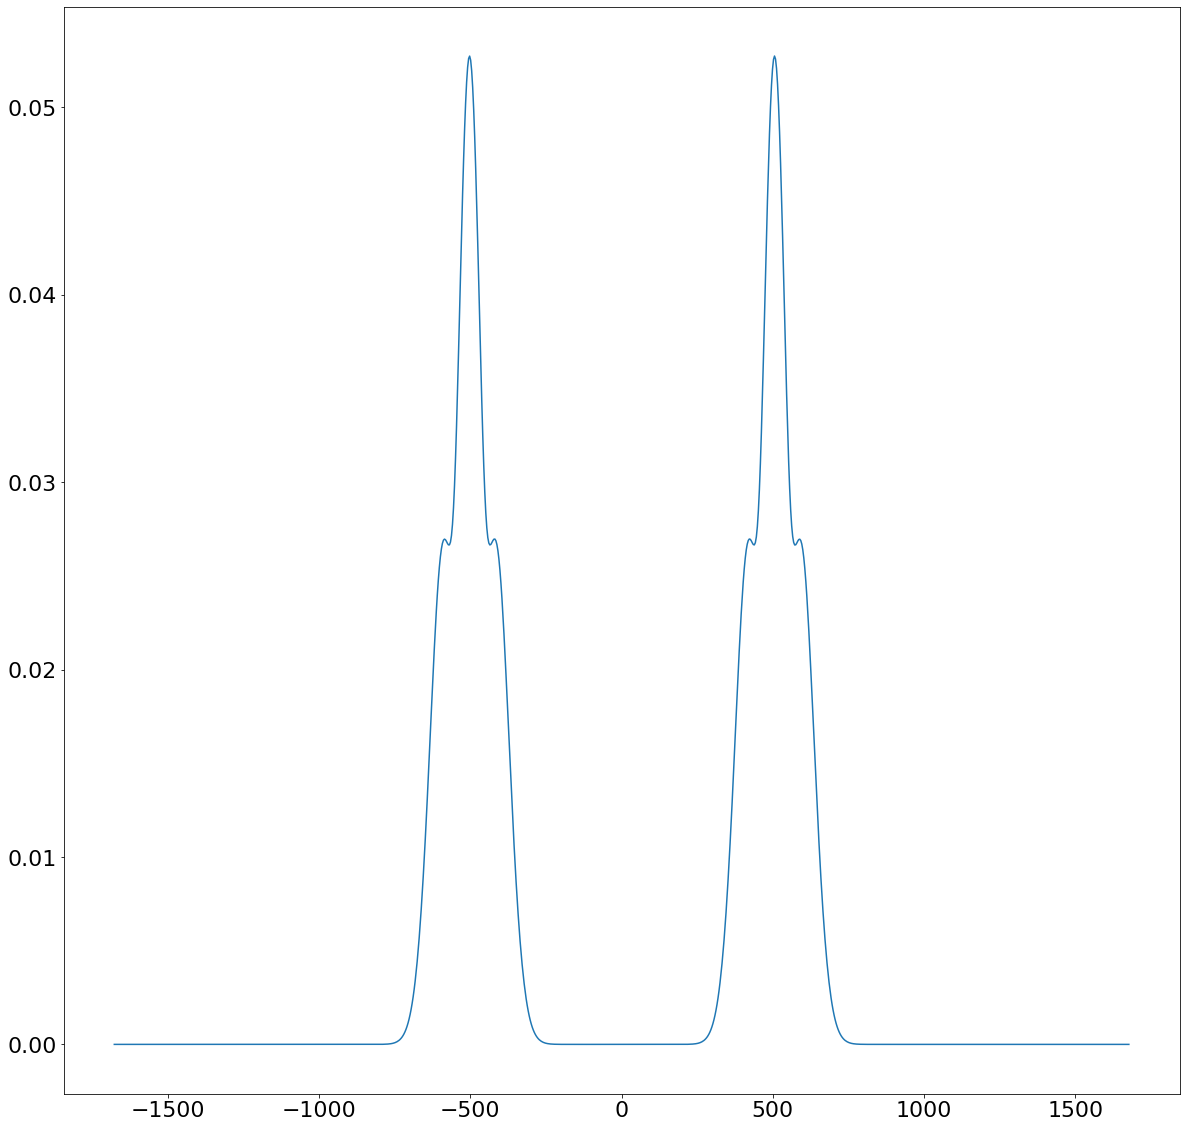

In [19]:
plt.plot(np.linspace(-xrange,xrange,q.shape[0]),np.abs(q[np.int(q.shape[0]/2),:]))

## Multistage diffraction

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

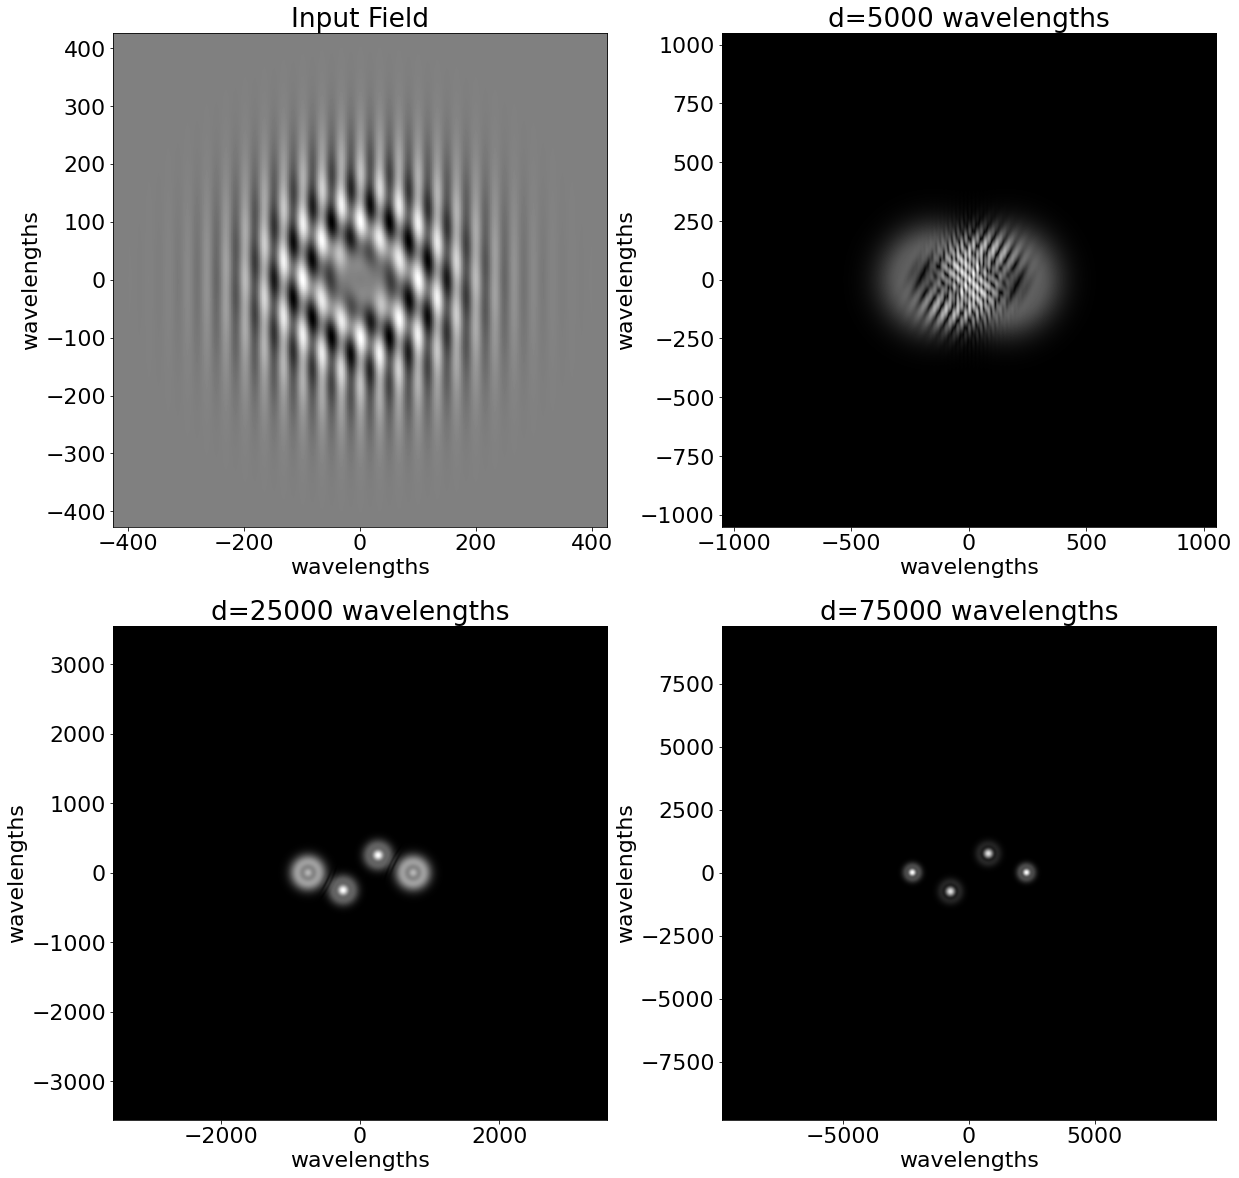

In [20]:
## Angular spectrum propagation with resampling. Since the field is getting bigger and lower frequency as it propagetes,we periodically downsample to allow larger effective window size. 
N=256
lam=.3
xrange=N/(lam*2)
xp=np.linspace(-xrange,xrange,N)
x,y = np.meshgrid(xp,xp)
f=np.cos(.06*np.pi*x)*(np.exp(-(x**2+y**2)/23000)-np.exp(-(x**2+y**2)/16000))+np.cos(.02*np.pi*(x-y))*(np.exp(-(x**2+y**2)/10000)-np.exp(-(x**2+y**2)/7000))
plt.subplot(2,2,1)
plt.imshow(f,extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('Input Field')
d=5000
q=g(f,d,lam)
xrange=q.shape[0]/(lam*2)
plt.subplot(2,2,2)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('d=5000 wavelengths')
qq=rescale(np.real(q),.5,order=3, mode='constant') +1j*rescale(np.imag(q),.5,order=3, mode='constant')
#
#
d=20000
lam=lam/2
qq=g(qq,d,lam)
xrange=qq.shape[0]/(lam*2)
plt.subplot(2,2,3)
plt.imshow(np.abs(qq),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('d=25000 wavelengths')
d=50000
qg=rescale(np.real(qq),.5) +1j*rescale(np.imag(qq),.5)
lam=.5*lam
qg=g(qg,d,lam)
xrange=qg.shape[0]/(lam*2)
plt.subplot(2,2,4)
plt.imshow(np.abs(qg),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('d=75000 wavelengths')
plt.savefig('multiStep.pdf')
files.download('multiStep.pdf')

## Diffraction to focus

Of course, the field does not always blur as it diffracts. A properly phased field can focus as it diffracts. Here is an example. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

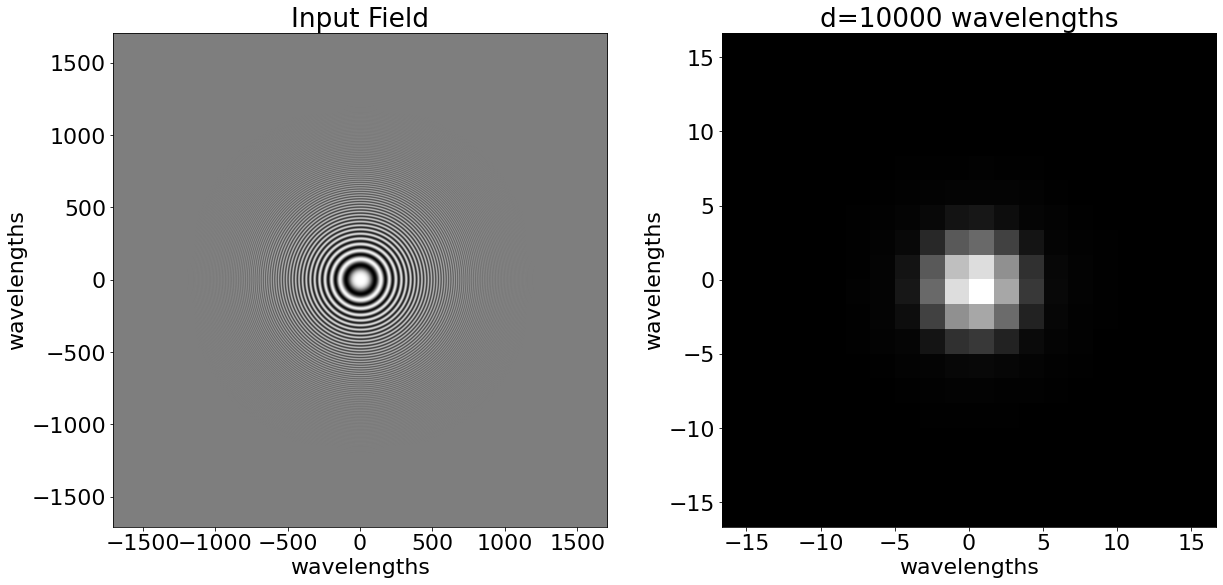

In [25]:
## Focusing Chirp Distribution
N=1024
lam=.3
xrange=N/(lam*2)
xp=np.linspace(-xrange,xrange,N)
x,y = np.meshgrid(xp,xp)
f=np.exp(-(x**2+y**2)/400000)*np.exp(-np.pi*1j*(x**2+y**2)/10000)
plt.subplot(2,2,1)
plt.imshow(np.real(f),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('Input Field')
d=10000
q=g(f,d,lam)
xrange=q.shape[0]/(lam*2)
plt.subplot(2,2,2)
pip=q.shape[0]
plt.imshow(np.abs(q[np.int(pip/2-10):np.int(pip/2+10),np.int(pip/2-10):np.int(pip/2+10)]),extent=[-10/(lam*2),10/(lam*2),-10/(lam*2),10/(lam*2)],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.title('d=10000 wavelengths')
plt.savefig('ASMfocus.pdf')
files.download('ASMfocus.pdf')


## Further reading

Various numerical diffraction modeling strategies are discussed and compared in Zhang, Wenhui & Zhang, Hao & Sheppard, Colin & Jin, Guofan. (2020). Analysis of numerical diffraction calculation methods: from the perspective of phase space optics and the sampling theorem. Journal of the Optical Society of America A. 10.1364/JOSAA.401908. 